# **CycleGAN**
### Style Transfer 2.0🐎🦓

<br>

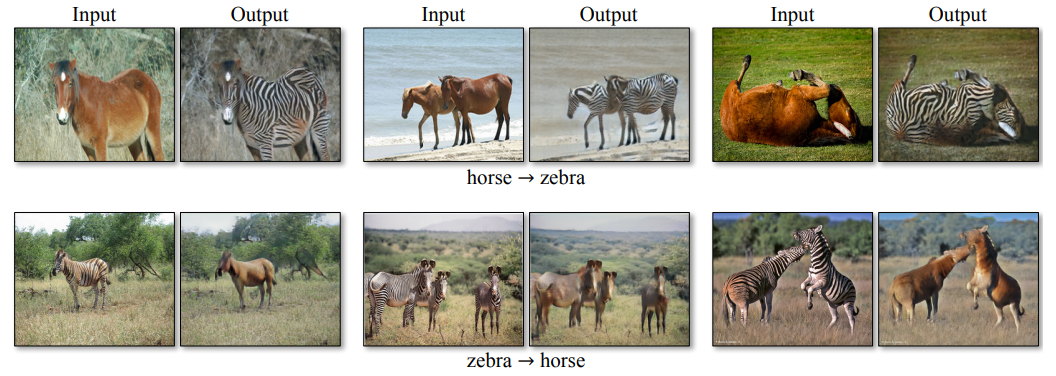

**CycleGAN** was released in 2017 and it kinda blows mind!<br>
It simultaneously trains "translator" generators to turn textrue1->texture2 and texture2->texture1 on the objects or on an entire image.<br>
We can use them for style transfering, for object change (note, CycleGANs work only for changin textures, not geometry, so we can turn horse into a zebra or an orange into an apple, but not cat into dog.)<br>
But how does it work?<br>

## **Principle**
we train 2 generators, each recieves an image and regenerates from it to make a change, then discriminator determines whether the image is fake or not (we use patch discriminator, so that it's more flexible), we calculate loss for both generators, but we also calculate a cycle loss.<br>
Cycle loss is a L1Loss on reconstruction from fake (fake horse back to zebra - original image used for the fake horse and vice a versa).<br>
Complete loss is:<br>

$$L = L_{G1} + L_{G2} + \gamma L_{cycle1} + \gamma L_{cycle2}$$

CycleGAN is easy, actually

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Step 1. Load The Data.

In [ ]:
# DataSet Creation
class ZebraHorseDataset(Dataset):
  def __init__(self, zebras_root, horses_root, transform=None):
    self.zebras_root = zebras_root
    self.horses_root = horses_root
    self.transform = transform

    self.zebras = os.listdir(zebras_root)
    self.horses = os.listdir(horses_root)
    self.len_zebras = len(self.zebras)
    self.len_horses = len(self.horses)
    self.dataset_len = min(self.len_zebras, self.len_horses)

  def __len__(self):
    return self.dataset_len

  def __getitem__(self, idx):
    zebra = self.zebras[idx]
    horse = self.horses[idx]
    zebra_img = Image.open(os.path.join(self.zebras_root, zebra)).convert("RGB")
    horse_img = Image.open(os.path.join(self.horses_root, horse)).convert("RGB")
    if self.transform:
      zebra_img = self.transform(zebra_img)
      horse_img = self.transform(horse_img)
    return zebra_img, horse_img

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ZebraHorseDataset("/content/zebras", "/content/horses", transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
len(dataset)

1067

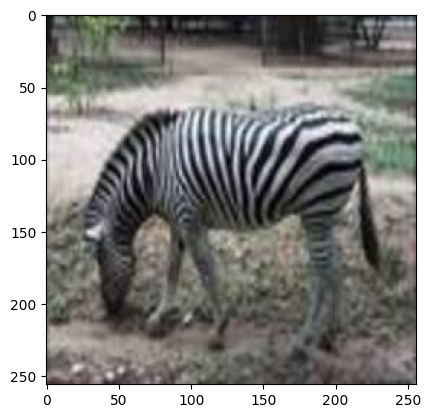

In [ ]:
plt.imshow((dataset[54][0] * 0.5 + 0.5).permute(1, 2, 0));

### Step 2. Discriminator and Generator implementation.

In [9]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(in_channels)
    )

  def forward(self, input):
    return input + self.block(input)


# Generator
class Generator(nn.Module):
  def __init__(self, hidden_size, n_residuals=9):
    super().__init__()
    # Initial Block
    self.initial = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, padding=3, padding_mode="reflect"),  # (B, 64, 256, 256)
        nn.InstanceNorm2d(64),
        nn.ReLU()
    )
    # Downsampling (Encoding)
    self.downsample = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, padding_mode="reflect"),  # (B, 128, 128, 128)
        nn.InstanceNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, padding_mode="reflect"),  # (B, 256, 64, 64)
        nn.InstanceNorm2d(256),
        nn.ReLU()
    )
    # Residual Blocks (transform)
    self.residual = nn.Sequential(
        *[ResidualBlock(256) for _ in range(n_residuals)]  # (B, 256, 64, 64)
        )
    # Upsampling (Decoding)
    self.upsample = nn.Sequential(
      nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.InstanceNorm2d(128),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.InstanceNorm2d(64),
      nn.ReLU()
    )
    # Output Block
    self.final = nn.Sequential(
        nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),  # (B, 3, 256, 256)
        nn.Tanh()
    )

  def forward(self, input):
    return self.final(
        self.upsample(
            self.residual(
                self.downsample(
                    self.initial(input)
                    )
                )
            )
        )

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    # Initial Block
    self.initial = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),  # (B, 64, 128, 128)
        nn.LeakyReLU(0.2)
    )
    # Downsampling Block
    self.downsample = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),  # (B, 128, 64, 64)
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),  # (B, 256, 32, 32)
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2)
    )
    # Output Block
    self.output = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),  # PyTorch adds only 1 pixel for even ks
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
    )
  def forward(self, input):
    return self.output(
        self.downsample(
            self.initial(input)
            )
        )

In [ ]:
# Testing Correctness of Shapes

noise = torch.randn(5, 3, 256, 256)
gen_out = Generator(64)(noise)
disc_out = Discriminator()(noise)

print(gen_out.shape)
print(disc_out.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 1, 30, 30])


### Step 3. Train.

In [ ]:
from tqdm import tqdm

In [ ]:
zebra_generator = Generator(64).to(device)
horse_generator = Generator(64).to(device)

zebra_discriminator = Discriminator().to(device)
horse_discriminator = Discriminator().to(device)

loss_fn = nn.MSELoss()
l1 = nn.L1Loss()

gen_optim = optim.Adam(list(zebra_generator.parameters()) + list(horse_generator.parameters()), lr=2e-4, betas=(0.5, 0.999))
disc_optim = optim.Adam(list(zebra_discriminator.parameters()) + list(horse_discriminator.parameters()), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
for zeb, hor in dataloader:
  print(zeb.shape)
  print(hor.shape)
  break

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [ ]:
"""TRAIN LOOP # 1"""
EPOCHS = 20

cycle_lambda = 10
lambda_identity = 0.5

for epoch in range(EPOCHS):
  for i, (zebra_batch, horse_batch) in enumerate(tqdm(dataloader)):
    zebra_batch = zebra_batch.to(device)
    horse_batch = horse_batch.to(device)
    # ===Discriminators Loss===
    # zebras
    fake_zebra = zebra_generator(horse_batch)
    d_fake_zebra = zebra_discriminator(fake_zebra.detach())
    d_real_zebra = zebra_discriminator(zebra_batch)
    d_fake_zebra_loss = loss_fn(d_fake_zebra, torch.zeros_like(d_fake_zebra, device=device))
    d_real_zebra_loss = loss_fn(d_real_zebra, torch.ones_like(d_real_zebra, device=device))
    d_zebra_loss = d_fake_zebra_loss + d_real_zebra_loss
    # horses
    fake_horse = horse_generator(zebra_batch)
    d_fake_horse = horse_discriminator(fake_horse.detach())
    d_real_horse = horse_discriminator(horse_batch)
    d_fake_horse_loss = loss_fn(d_fake_horse, torch.zeros_like(d_fake_horse, device=device))
    d_real_horse_loss = loss_fn(d_real_horse, torch.ones_like(d_real_horse, device=device))
    d_horse_loss = d_fake_horse_loss + d_real_horse_loss

    d_loss = (d_zebra_loss + d_horse_loss) / 2
    disc_optim.zero_grad()
    d_loss.backward()
    disc_optim.step()
    # ===Generators Loss===
    g_zebra_loss = loss_fn(zebra_discriminator(fake_zebra), torch.ones_like(d_fake_zebra, device=device))
    g_horse_loss = loss_fn(horse_discriminator(fake_horse), torch.ones_like(d_fake_horse, device=device))

    # ===Cycle Loss===
    cycle_zebra = zebra_generator(fake_horse)
    cycle_zebra_loss = l1(cycle_zebra, zebra_batch)
    cycle_horse = horse_generator(fake_zebra)
    cycle_horse_loss = l1(cycle_horse, horse_batch)

    # ===Identity Loss===
    identity_zebra = zebra_generator(zebra_batch)
    identity_loss_zebra = l1(identity_zebra, zebra_batch)

    identity_horse = horse_generator(horse_batch)
    identity_loss_horse = l1(identity_horse, horse_batch)

    # Overall Loss
    g_loss = (g_zebra_loss +
                 g_horse_loss + cycle_lambda * (cycle_zebra_loss + cycle_horse_loss) +
                 lambda_identity * (identity_loss_zebra + identity_loss_horse))
    gen_optim.zero_grad()
    g_loss.backward()
    gen_optim.step()

    if i % 200 == 0:
      # Save params
      torch.save(zebra_generator.state_dict(), f"/content/drive/MyDrive/weights/gen_z{i}.pth")
      torch.save(horse_generator.state_dict(), f"/content/drive/MyDrive/weights/gen_h{i}.pth")
      torch.save(zebra_discriminator.state_dict(), f"/content/drive/MyDrive/weights/disc_z{i}.pth")
      torch.save(horse_discriminator.state_dict(), f"/content/drive/MyDrive/weights/disc_h{i}.pth")

      print(f"Epoch: {epoch} | i: {i} | gen_loss: {g_loss.item()} | dis_loss: {d_loss.item()} | zebra_g_loss: {g_zebra_loss.item()} | horse_g_loss: {g_horse_loss.item()} | cycle_loss: {(cycle_lambda * (cycle_zebra_loss + cycle_horse_loss)).item()} identity_loss: {(lambda_identity * (identity_loss_zebra + identity_loss_horse)).item()}")
      plt.figure(figsize=(5, 5))
      plt.imshow(((fake_zebra + 1) / 2).cpu().clone().squeeze(0).permute(1, 2, 0).detach().numpy())
      plt.show()

### Step 4. Test!

In [11]:
zebra_generator = Generator(64).to(device)
horse_generator = Generator(64).to(device)

zebra_discriminator = Discriminator().to(device)
horse_discriminator = Discriminator().to(device)

loss_fn = nn.MSELoss()
l1 = nn.L1Loss()

gen_optim = optim.Adam(list(zebra_generator.parameters()) + list(horse_generator.parameters()), lr=1e-4, betas=(0.5, 0.999))
disc_optim = optim.Adam(list(zebra_discriminator.parameters()) + list(horse_discriminator.parameters()), lr=1e-4, betas=(0.5, 0.999))

In [12]:
horse_generator.load_state_dict(torch.load("/content/gen_h200.pth", weights_only=True))
zebra_generator.load_state_dict(torch.load("/content/gen_z200.pth", weights_only=True))
horse_discriminator.load_state_dict(torch.load("/content/disc_h200.pth", weights_only=True))
zebra_discriminator.load_state_dict(torch.load("/content/disc_z200.pth", weights_only=True))

<All keys matched successfully>

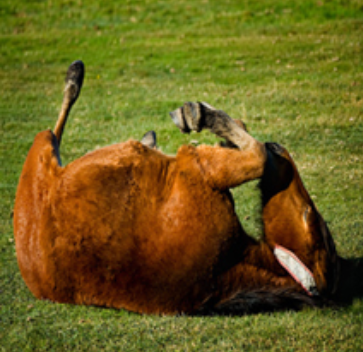

In [22]:
img = Image.open("/content/horse.png").convert("RGB")
img

In [33]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

horse = transform(img).unsqueeze(0).to(device)
horse.shape

torch.Size([1, 3, 256, 256])

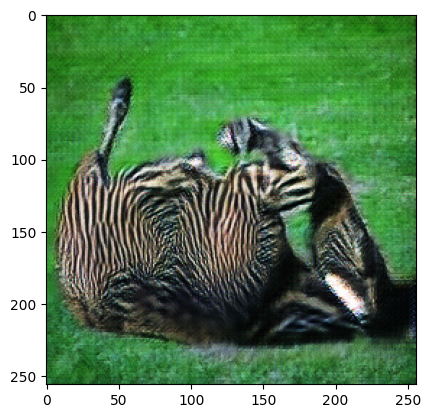

In [34]:
zebra_generator.eval()
with torch.inference_mode():
  new_zebra = zebra_generator(horse)
  plt.imshow(((new_zebra + 1) / 2).squeeze(0).cpu().permute(1, 2, 0).detach().numpy());

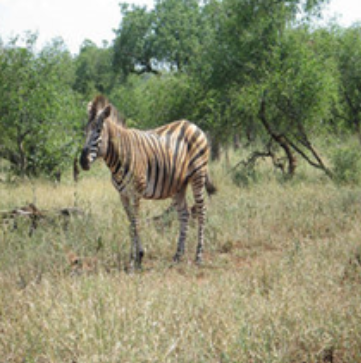

In [52]:
img = Image.open("/content/zebra.png").convert("RGB")
img

In [55]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

zebra = transform(img).unsqueeze(0).to(device)
zebra.shape

torch.Size([1, 3, 256, 256])

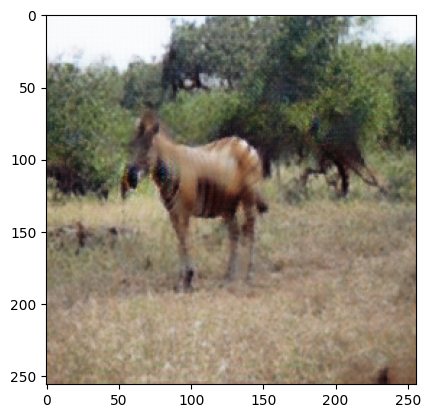

In [56]:
horse_generator.eval()
with torch.inference_mode():
  new_horse = horse_generator(horse)
  plt.imshow(((new_horse + 1) / 2).squeeze(0).cpu().permute(1, 2, 0).detach().numpy());

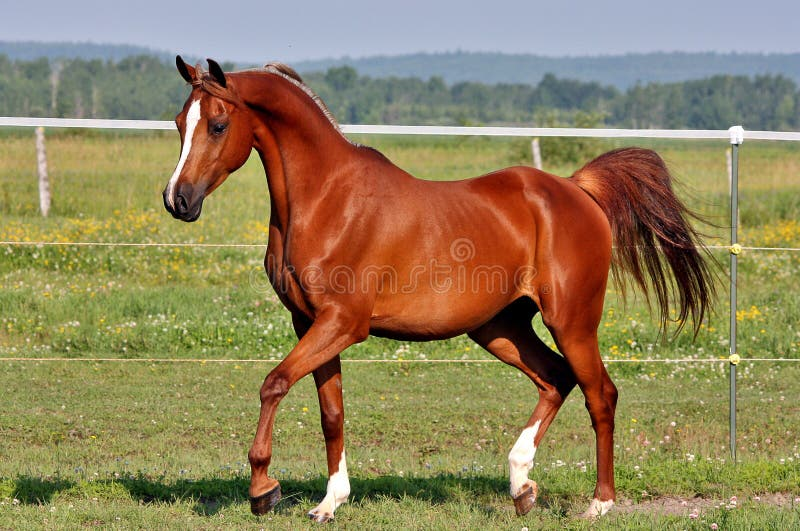

In [57]:
img = Image.open("/content/horse3.png").convert("RGB")
img

In [58]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

horse = transform(img).unsqueeze(0).to(device)
horse.shape

torch.Size([1, 3, 256, 256])

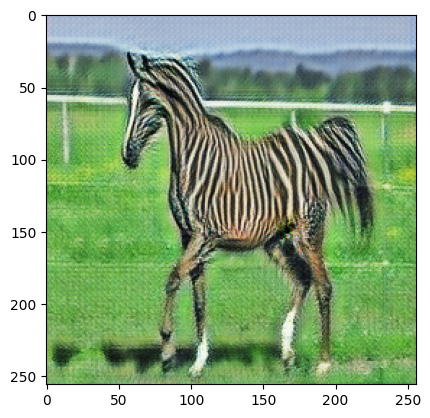

In [59]:
zebra_generator.eval()
with torch.inference_mode():
  new_zebra = zebra_generator(horse)
  plt.imshow(((new_zebra + 1) / 2).squeeze(0).cpu().permute(1, 2, 0).detach().numpy());

# **Well, IT'S COOL!**
Technically, we could do better, I could train for longer, but I achieved good looking results and it's super cool!<br>
Weights Link: https://drive.google.com/drive/folders/1MKL-ceW_5x5tRGW4vj_6wG5G2T1-ZwKZ?usp=sharing